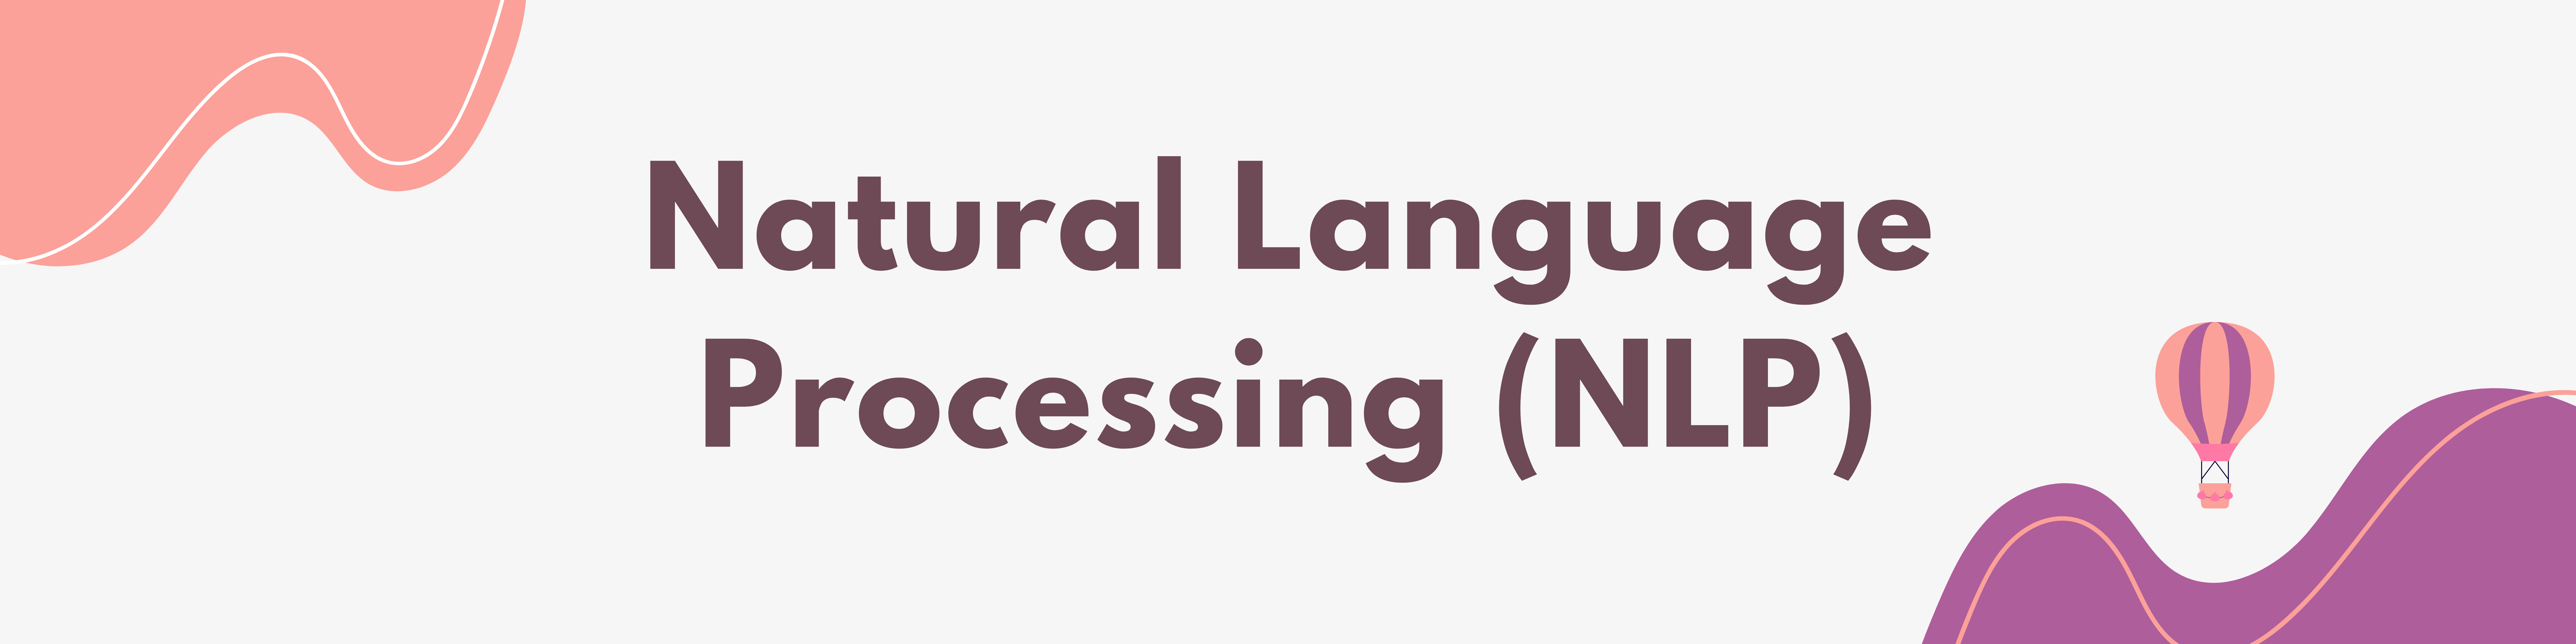

## Instalación de librerías

- Pyspark: https://spark.apache.org/docs/latest/api/python/
- Visualización de temáticas con pyLDAvis: https://pypi.org/project/pyLDAvis/

In [1]:
!pip install pyspark
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=3a1a86806771745978a209e77131c108949a07e01554f045f6b00784228abca9
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 100.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.

**Importar librerías**

Importamos librerías para el preprocesamiento de texto, LDA y visualización.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, lower, size, explode, split, expr
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, NGram
from pyspark.ml.clustering import LDA
from collections import Counter
import numpy as np

import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Lectura de base

 **Crear sesión de Spark**

In [2]:
spark = SparkSession.builder\
        .appName("Colab")\
        .getOrCreate()

**Leer información de Reddit**

In [3]:
# La base no tiene encabezado
df = spark.read.option("header",True).csv("/content/part-00001-ffe5093e-9eae-438a-a17f-cd8a64881b75-c000.csv")

df.printSchema()

root
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- post_id: string (nullable = true)



Eliminar duplicados:

In [4]:
df = df.select(['title','author']).dropDuplicates()

df.count()
# Tamaño de la base: 100 registros

100

## Preprocesamiento de texto

Normalizar:

- Pasar texto en minúsculas
- Símbolos y caracteres especiales 

In [5]:
df_clean = df.select('title', (lower(regexp_replace('title', "[^a-zA-Z\w\s+]", "")).alias('text')))

df_clean.show()

+--------------------+--------------------+
|               title|                text|
+--------------------+--------------------+
|Getting Started w...|getting started w...|
|Python for Financ...|python for financ...|
|Interactive visua...|interactive visua...|
|I created a Pytho...|i created a pytho...|
|Epic Base Conversion|epic base conversion|
|Easy Machine Lear...|easy machine lear...|
|📣 Announcement: ...| announcement dis...|
|The Python Langua...|the python langua...|
|Crack the Coding ...|crack the coding ...|
|Choosing the Best...|choosing the best...|
|I wrote a Python ...|i wrote a python ...|
|python webdriver ...|python webdriver ...|
|The Python Langua...|the python langua...|
|FastKafka 0.7.0 a...|fastkafka 070 add...|
|Wrote an open sou...|wrote an open sou...|
|Reading the stack...|reading the stack...|
|Here's my falling...|heres my falling ...|
|Benchmarking for ...|benchmarking for ...|
|How to connect to...|how to connect to...|
|The Fedora Python...|the fedora 

Eliminar registros nulos:

In [6]:
df_clean = df_clean.filter(df_clean.text.isNotNull())
df_clean.na.drop(subset=["text"])
df_clean = df_clean.filter(df_clean.text != "")

df_clean.show()

+--------------------+--------------------+
|               title|                text|
+--------------------+--------------------+
|Getting Started w...|getting started w...|
|Python for Financ...|python for financ...|
|Interactive visua...|interactive visua...|
|I created a Pytho...|i created a pytho...|
|Epic Base Conversion|epic base conversion|
|Easy Machine Lear...|easy machine lear...|
|📣 Announcement: ...| announcement dis...|
|The Python Langua...|the python langua...|
|Crack the Coding ...|crack the coding ...|
|Choosing the Best...|choosing the best...|
|I wrote a Python ...|i wrote a python ...|
|python webdriver ...|python webdriver ...|
|The Python Langua...|the python langua...|
|FastKafka 0.7.0 a...|fastkafka 070 add...|
|Wrote an open sou...|wrote an open sou...|
|Reading the stack...|reading the stack...|
|Here's my falling...|heres my falling ...|
|Benchmarking for ...|benchmarking for ...|
|How to connect to...|how to connect to...|
|The Fedora Python...|the fedora 

Tokenizar:

In [7]:
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select(expr("filter(words_token, x -> x != '') as words_token"))

df_words_token.show()

+--------------------+
|         words_token|
+--------------------+
|[getting, started...|
|[python, for, fin...|
|[interactive, vis...|
|[i, created, a, p...|
|[epic, base, conv...|
|[easy, machine, l...|
|[announcement, di...|
|[the, python, lan...|
|[crack, the, codi...|
|[choosing, the, b...|
|[i, wrote, a, pyt...|
|[python, webdrive...|
|[the, python, lan...|
|[fastkafka, 070, ...|
|[wrote, an, open,...|
|[reading, the, st...|
|[heres, my, falli...|
|[benchmarking, fo...|
|[how, to, connect...|
|[the, fedora, pyt...|
+--------------------+
only showing top 20 rows



Remover stopwords:

In [8]:
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('words_clean')

df_words_no_stopw.show()

+--------------------+
|         words_clean|
+--------------------+
|[getting, started...|
|[python, finance,...|
|[interactive, vis...|
|[created, python,...|
|[epic, base, conv...|
|[easy, machine, l...|
|[announcement, di...|
|[python, language...|
|[crack, coding, i...|
|[choosing, best, ...|
|[wrote, python, p...|
|[python, webdrive...|
|[python, language...|
|[fastkafka, 070, ...|
|[wrote, open, sou...|
|[reading, stack, ...|
|[heres, falling, ...|
|[benchmarking, du...|
|[connect, s3, loc...|
|[fedora, python, ...|
+--------------------+
only showing top 20 rows



## Implementación de Latent Dirichlet Allocation (LDA) 

Vectorizar las palabras:

In [9]:
Vector = CountVectorizer(inputCol="words_clean", outputCol="features")
result_vector = Vector.fit(df_words_no_stopw)
result = result_vector.transform(df_words_no_stopw)

result.show()

+--------------------+--------------------+
|         words_clean|            features|
+--------------------+--------------------+
|[getting, started...|(498,[35,42,50,13...|
|[python, finance,...|(498,[0,70,229,27...|
|[interactive, vis...|(498,[20,33,42,46...|
|[created, python,...|(498,[0,1,5,32,39...|
|[epic, base, conv...|(498,[252,421,422...|
|[easy, machine, l...|(498,[21,24,27,40...|
|[announcement, di...|(498,[181,285,296...|
|[python, language...|(498,[0,8,19,28,6...|
|[crack, coding, i...|(498,[10,85,200,2...|
|[choosing, best, ...|(498,[0,10,67,80,...|
|[wrote, python, p...|(498,[0,3,49,60,7...|
|[python, webdrive...|(498,[0,2,7,204,3...|
|[python, language...|(498,[0,8,19,66,1...|
|[fastkafka, 070, ...|(498,[41,205,240,...|
|[wrote, open, sou...|(498,[1,60,63,75,...|
|[reading, stack, ...|(498,[0,128,238,2...|
|[heres, falling, ...|(498,[77,87,90,16...|
|[benchmarking, du...|(498,[29,65,474],...|
|[connect, s3, loc...|(498,[3,9,49,52,9...|
|[fedora, python, ...|(498,[0,15

LDA:

In [10]:
num_topics = 3 # Número de temáticas
max_iterations = 10 # Cantidad de iteraciones 

# LDA
lda = LDA(k=num_topics, maxIter=max_iterations, seed= 3, featuresCol='features') 
lda_model = lda.fit(result)

## Temáticas

Obtener temáticas:

In [11]:
wordNumbers = 40 # Cantidad de palabras por temática

topics = lda_model.describeTopics(maxTermsPerTopic = wordNumbers).select('termIndices').collect() # Obtener los términos más representativos de cada temática

for topic in topics:
  words = [result_vector.vocabulary[i] for i in topic[0]] # Mapear los términos
  print(words)
    
document_topics = lda_model.transform(result)
document_topics.show()

['python', 'using', 'errors', 'stack', 'understand', 'trace', 'reading', 'gmail', 'framework', 'summit', 'weeks', 'package', 'simple', 'agi', 'language', 'easily', 'metas', 'project', 'mms', 'use', 'speech', 'multilingual', '2023', 'email', 'library', 'massively', 'creating', 'agents', 'autonomous', '2', 'script', 'update', 'find', 'solve', 'prompt', 'redditors', 'new', 'font', 'pandas', 'updated']
['daily', 'thread', 'polars', 'beginner', 'questions', 'wednesday', 'data', 'duckdb', 'streamlit', 'cli', 'self', 'application', 'research', 'csv', 'medical', 'packaging', 'started', 'environment', 'contained', 'benchmarking', 'visualizations', 'getting', 'extract', 'variablesfunctions', 'transcript', 'audio', 'library', 'large', 'private', 'made', 'worth', 'text', 'start', 'talk', 'new', 'tools', 'automatically', 'visualize', 'parser', 'using']
['development', 'list', 'selection', 'input', 'sparklines', 'validation', 'tips', 'tool', 'textual', '0270', 'whats', 'adds', 'coding', 'declarative

In [12]:
from pyspark.sql.functions import col
document_topics.collect()[0][2]

DenseVector([0.0488, 0.9068, 0.0444])

### WordCloud por temática

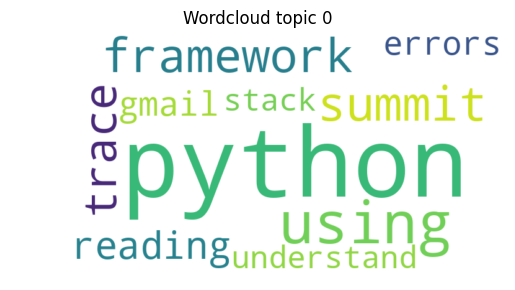

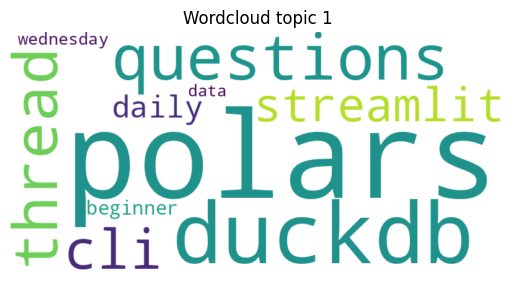

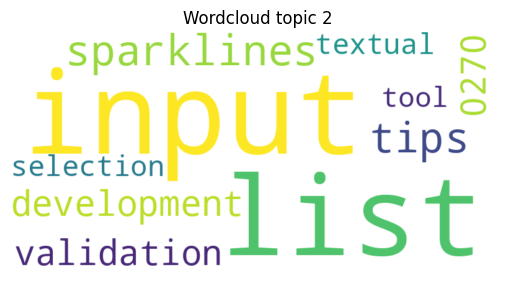

In [13]:
for i in range(num_topics):
  topic_words = [result_vector.vocabulary[idx] for idx in lda_model.describeTopics().select('termIndices').collect()[i][0]] # Obtener los términos de cada temática
  word_freqs = dict(zip(topic_words, lda_model.topicsMatrix().toArray()[:, i])) # Unir términos de los temas a sus frecuencias 
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freqs)
  plt.figure()
  plt.title(f'Wordcloud topic {i}')
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

### N-gramas

In [14]:
n = 2  # Número de elementos por n-grama (en este caso, bigramas)
input_col = "words_clean"  # Nombre de la columna que contiene el texto
output_col = "ngramas"  # Nombre de la columna que contendrá los bigramas

# Crea un objeto NGram con los parámetros especificados
ngram_transformer = NGram(n=n, inputCol=input_col, outputCol=output_col)

# Aplica la transformación a los datos de entrada y guarda el resultado en un nuevo DataFrame
dataframe_con_bigramas = ngram_transformer.transform(result)

In [15]:
dataframe_con_bigramas.show()

+--------------------+--------------------+--------------------+
|         words_clean|            features|             ngramas|
+--------------------+--------------------+--------------------+
|[getting, started...|(498,[35,42,50,13...|[getting started,...|
|[python, finance,...|(498,[0,70,229,27...|[python finance, ...|
|[interactive, vis...|(498,[20,33,42,46...|[interactive visu...|
|[created, python,...|(498,[0,1,5,32,39...|[created python, ...|
|[epic, base, conv...|(498,[252,421,422...|[epic base, base ...|
|[easy, machine, l...|(498,[21,24,27,40...|[easy machine, ma...|
|[announcement, di...|(498,[181,285,296...|[announcement dis...|
|[python, language...|(498,[0,8,19,28,6...|[python language,...|
|[crack, coding, i...|(498,[10,85,200,2...|[crack coding, co...|
|[choosing, best, ...|(498,[0,10,67,80,...|[choosing best, b...|
|[wrote, python, p...|(498,[0,3,49,60,7...|[wrote python, py...|
|[python, webdrive...|(498,[0,2,7,204,3...|[python webdriver...|
|[python, language...|(49

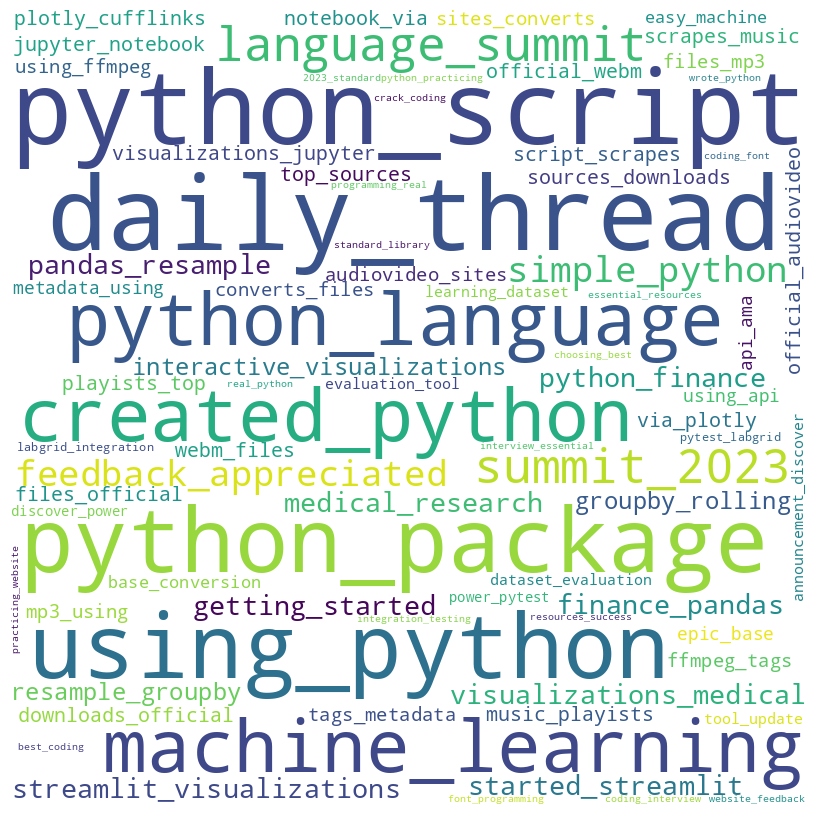

In [16]:
# WordCloud de n-gramas

ngramas_list = [i.ngramas for i in dataframe_con_bigramas.select("ngramas").collect()] # Crear una lista con los n-gramas

palabras = ["_".join(palabra.split()) for lista in ngramas_list for palabra in lista if len(set(palabra.split())) > 1] # Unir n-gramas por _

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(" ".join(palabras))
                  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [17]:
Counter(palabras).most_common(10) # n-gramas más comunes

[('python_script', 4),
 ('daily_thread', 4),
 ('python_package', 3),
 ('using_python', 3),
 ('created_python', 2),
 ('machine_learning', 2),
 ('python_language', 2),
 ('language_summit', 2),
 ('summit_2023', 2),
 ('feedback_appreciated', 2)]

### pyLDAvis

Gráfica de temáticas:

In [19]:
# Dar formato a los datos para graficar
def format_data_to_pyldavis(clean_df, count_vectorizer, df_topics, lda_model):
  """
    Ordenar datos de entrada para graficar temáticas con pyLDAvis.

    Input:
      clean_df: Dataframe luego de limpieza y tokenización.
      count_vectorizer: CountVectorizerModel que permite extraer un voculario de una colección de documentos.
      df_topics: Dataframe con asignación de tópicos a cada registro.
      lda_model: Modelo LDA.

    Return:
      Diccionario con base lista para gráficar:
      - Matriz de distribución de términos por tema (topic_term_dists)
      - Matriz de distribución de temas por documento (doc_topic_dists)
      - Lista de longitudes de documentos (doc_lengths)
      - Vocabulario de palabras (vocab)
      - Lista de conteos de palabras (term_frequency)
  """
  
  word_frequency = clean_df.select((explode(clean_df.words_clean)).alias("words")).groupby("words").count() # Lista de palabras y su frecuencia
  word_counts = {r['words']:r['count'] for r in word_frequency.collect()} # Diccionario palabra: cantidad
  word_counts = [word_counts[w] for w in count_vectorizer.vocabulary] # Contiene las palabras en el vocabulario de CountVectorizer

  data = {'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T, 
          'doc_topic_dists': np.array([x.toArray() for x in df_topics.select(["topicDistribution"]).toPandas()['topicDistribution']]),
          'doc_lengths': [r[0] for r in clean_df.select(size(clean_df.words_clean)).collect()],
          'vocab': count_vectorizer.vocabulary,
          'term_frequency': word_counts}

  return data

# Filtrar solo registros válidos
def filter_bad_docs(data):
  bad = 0
  doc_topic_dists_filtrado = [] 
  doc_lengths_filtrado = []

  for x,y in zip(data['doc_topic_dists'], data['doc_lengths']):
      if np.sum(x)==0:
          bad+=1
      elif np.sum(x) != 1:
          bad+=1
      elif np.isnan(x).any():
          bad+=1
      else:
          doc_topic_dists_filtrado.append(x)
          doc_lengths_filtrado.append(y)

  data['doc_topic_dists'] = doc_topic_dists_filtrado
  data['doc_lengths'] = doc_lengths_filtrado

# Ordenar base para gráficar
data = format_data_to_pyldavis(df_words_no_stopw, result_vector, document_topics, lda_model)
filter_bad_docs(data) 

# Gráfica con pyLDAvis 
py_lda_prepared_data = pyLDAvis.prepare(**data)
pyLDAvis.display(py_lda_prepared_data)

Cerrar sesión de spark:

In [20]:
spark.stop()